By **2/17** Have results on the effects different algorithm parameters on algorithm performance as well as identifying bottlenecks in the control algorithm.

Paper Reference: https://arxiv.org/pdf/1804.05271.pdf

Relevant chart is Figure 4 shown below:
<img src="fig4.png">

The overall learning objective is to train a model to recognize hand written digits from the [MNIST database](https://en.wikipedia.org/wiki/MNIST_database) but instead of training the model on a centralized server, the training is split among worker nodes. Throughout my experiments, I assume the nodes are resource constrained and use that to guide decision making.

For this milestone, I will be focusing on the top left 2 images labelled SVM(DGD). SVM stands for Support Vector Machine which is an algorithm used for classifying items into a finite set of categories (like handwritten digits into categories 0-9). DGD is deterministic gradient descent which is the optimization method used to find the best parameters of the SVM to minimize misclassification.

The black line represents the baseline where all the data is located in a central location and used to train the SVM classifier. All other lines represent the case where data is distributed across multiple nodes. Cases 1-4 represent different distribution patters of the data across nodes (uniform, non-uniform, full dataset and mixture of uniform and non-uniform distribution across nodes).

The loss value represents the value of the objective being minimized by gradient descent to find good parameters to reduce misclassification and the loss objective varies by the learning algorithm. As an example, the loss for linear regression is the mean squared error between predicted class and true class. Accuracy is the percentage of test examples that were correctly classified by the learning model.

Each line shows the loss/accuracy at varying values of $\tau$ (time between successive global aggregation). The lines represent performance at each fixed value of $\tau$ while the shaped markers represent the average value of $\tau$ (the value is adaptive and changes during training based on resource constraints of the learning task) 

The experiments I'm going to run are to estimate how the following parameters affect the accuracy of the model as well as the training time required. In these experiments, I use 5 training nodes running as processes on the same AWS compute instance. I had some trouble getting AWS Elastic Container running before the milestone so I'll debug the setup after milestone 1. The goal of these experiments will be to trade some accuracy for less resource consumption.

1. Search range parameter ($\gamma$) with value 10 in the paper. This value is used to search for the optimal value of $\tau$, the time between global aggregations around the current value of $\tau$. So if $\gamma=10$, the new value of $\tau$ will be within 1 and $min{\gamma*\tau_{old},\tau_{max}}$ (line 20 of algorithm 2). I will use values [3,7,10] for the experiment. The motivation for selecting values lower than 10 is to make the search space smaller in order to save compute resources.

2. I make the maximum allowable time between succesive global aggregations $\tau_{max}$ larger than the value of 100 selected in the paper in order to allow for slower compute at the nodes if possible. Values used are [100,125,150].

3. The time budget for training the algorithm. Again, I use larger values than the value 15 used in the paper to allow for slower nodes due to minimal compute power at some edge nodes. I choose values [15,30,60].

Search space is $3^3=27$ and though it's not exhaustive, I hope to get an initial picture about possible interactions between these parameters.

In [9]:
import itertools

In [27]:
delta = [3, 7, 10]
tau_max = [100, 125, 200]
time_budget = [15, 30, 60]

all_combinations = list(itertools.product(delta, tau_max, time_budget))

In [28]:
len(all_combinations)

27

In [33]:
import sys
sys.path.append('..') # add previous directory to python path

from config import multi_run_results_file_path
from plot_multi_run import plot_results

Reproducing the top left diagrams from figure 4:

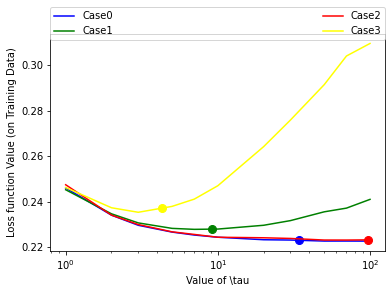

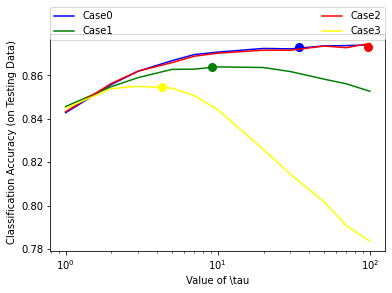

In [46]:
plot_results('../results/MultipleRuns_5_nodes_run1.csv')

Testing interactions using the case where data is distributed uniformly across the five nodes:

|gamma|tau max| time budget |Accuracy|Wall time(s)|
|:----:|:----------:|:-------------:|:------:|:-----:|
|3|100|15|0.8723|29.2996|
|3|100|30|0.8748|48.3260|
|3|100|60|0.8758|102.9359|
|3|125|15|0.8726|27.036|
|3|125|30|0.8752|47.2637|
|3|125|60|0.8754|100.549|
|3|200|15|0.8732|27.918|
|3|200|30|0.8752|46.793|
|3|200|60|0.877|101.198|


|gamma|tau max| time budget |Accuracy|Wall time(s)|
|:----:|:----------:|:-------------:|:------:|:-----:|
|7|100|15|0.8716|29.366|
|7|100|30|0.875|47.2803|
|7|100|60|0.8762|95.306|
|7|125|15|0.8727|27.0763|
|7|125|30|0.8748|45.419|
|7|125|60|0.8762|100.177|
|7|200|15|0.8726|28.974|
|7|200|30|0.8746|46.729|
|7|200|60|0.878|94.642|


|gamma|tau max| time budget |Accuracy|Wall time(s)|
|:----:|:----------:|:-------------:|:------:|:-----:|
|10|100|15|0.8732|26.848|
|10|100|30|0.8753|46.6732|
|10|100|60|0.8761|103.939|
|10|125|15|0.8728|27.716|
|10|125|30|0.8751|49.122|
|10|125|60|0.875|98.886|
|10|200|15|0.8731|28.183|
|10|200|30|0.8753|45.492|
|10|200|60|0.8751|99.672|

Preliminary results show that we can have a lot of slack (at least for the dataset and corresponding data distribution used) since the accuracy is able to stay within a similar range even when search range for $\tau$ is cut short and $\tau_{max}$ is increased. In this experiment, increase the time budget led to slight improvement in accuracy since the nodes weren't actually slowed down (that is, I didn't simulate nodes with less resources). It would be interesting to see if in the non-homoegeneous node resource case we get a fairer representation of what the accuracy would be.

It is not clear from the preliminary results though how varying the parameters together causes interactions among each other. From a cursory look, it appears each of them can be tuned independently. Generally, decreasing the search range led to slower convergence of the algorithm (so with fixed training time we would sacrifice a bit of accuracy), increasing $\tau_{max}$ had mixed results. To make the results clearer, I plan to plot the tuning separately for each parameter and use more fine grain tuning. 

Further exploration of algorithm relaxation will be to randomly skip some nodes during some cycles. The setup wasn't finished before milestone deadline but I'm curious to see how that performs. After that, the next step will be to measure the effects of communication conditions on the algorithm.

The github code can be found here: https://github.com/emma-mens/adaptive-federated-learning